In [13]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
import os
import re
from tqdm import tqdm
import pandas as pd

from rdkit import Chem
from rdkit.Chem import Draw

## Affinity -> SMILES でFine-tuningしたモデル

In [10]:
# 基本パラメータ
model_name = "cyberagent/open-calm-7b"
peft_name = "lora-calm-7b-ja-inverse"

# モデルの準備
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_8bit=True,
    device_map="auto",
)

# トークンナイザーの準備
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

# LoRAモデルの準備
model = PeftModel.from_pretrained(
    model, 
    peft_name, 
    device_map="auto"
)

# 評価モード
model.eval()

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.
Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  5.92s/it]


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPTNeoXForCausalLM(
      (gpt_neox): GPTNeoXModel(
        (embed_in): Embedding(52224, 4096)
        (layers): ModuleList(
          (0-31): 32 x GPTNeoXLayer(
            (input_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
            (post_attention_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
            (attention): GPTNeoXAttention(
              (rotary_emb): RotaryEmbedding()
              (query_key_value): Linear8bitLt(
                in_features=4096, out_features=12288, bias=True
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=12288, bias=False)
              

In [11]:
# テキスト生成関数の定義
def generate(prompt, maxTokens=128):
    # 推論
    input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
    outputs = model.generate(
        input_ids=input_ids, 
        max_new_tokens=maxTokens, 
        do_sample=True,
        temperature=0.7, 
        top_p=0.75, 
        top_k=40,         
        no_repeat_ngram_size=10,
        pad_token_id=tokenizer.eos_token_id
    )
    outputs = outputs[0].tolist()

    # EOSトークンにヒットしたらデコード完了
    if tokenizer.eos_token_id in outputs:
        eos_index = outputs.index(tokenizer.eos_token_id)
        decoded = tokenizer.decode(outputs[:eos_index])

        # レスポンス内容のみ抽出
        sentinel = "### Response:"
        sentinelLoc = decoded.find(sentinel)
        if sentinelLoc >= 0:
            out = decoded[sentinelLoc+len(sentinel):].strip()
            return out
        else:
            print('Warning: Expected prompt template to be emitted.  Ignoring output.')
    else:
        print('Warning: no <eos> detected ignoring output')

In [12]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
'E3ユビキチンリガーゼ(CBL-B)のTKBドメインに対して、提示された結合親和性の強度を有する化合物のSMILESを出力してください。'

### Input:
'非常に高い'

### Response:"""

out = generate(prompt)
out

'Cc1ccc(N2C(=O)c3ccccc3C2=O)cc1'

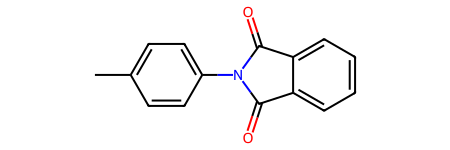

In [14]:
mol = Chem.MolFromSmiles('Cc1ccc(N2C(=O)c3ccccc3C2=O)cc1')
mol

In [16]:
out_list = []
for i in tqdm(range(100)):
    out_list.append(Chem.MolFromSmiles(generate(prompt)))

100%|██████████| 100/100 [09:51<00:00,  5.92s/it]


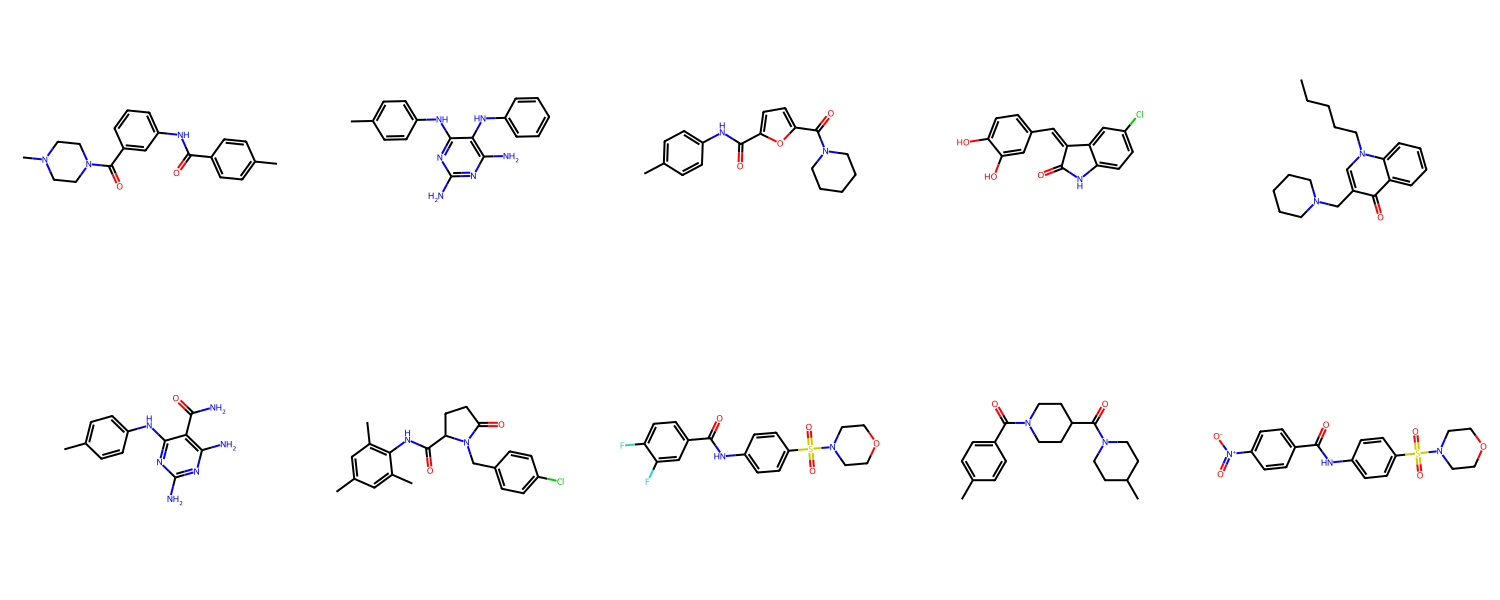

In [34]:
Draw.MolsToGridImage(out_list[:10],molsPerRow=5, subImgSize=(300,300))

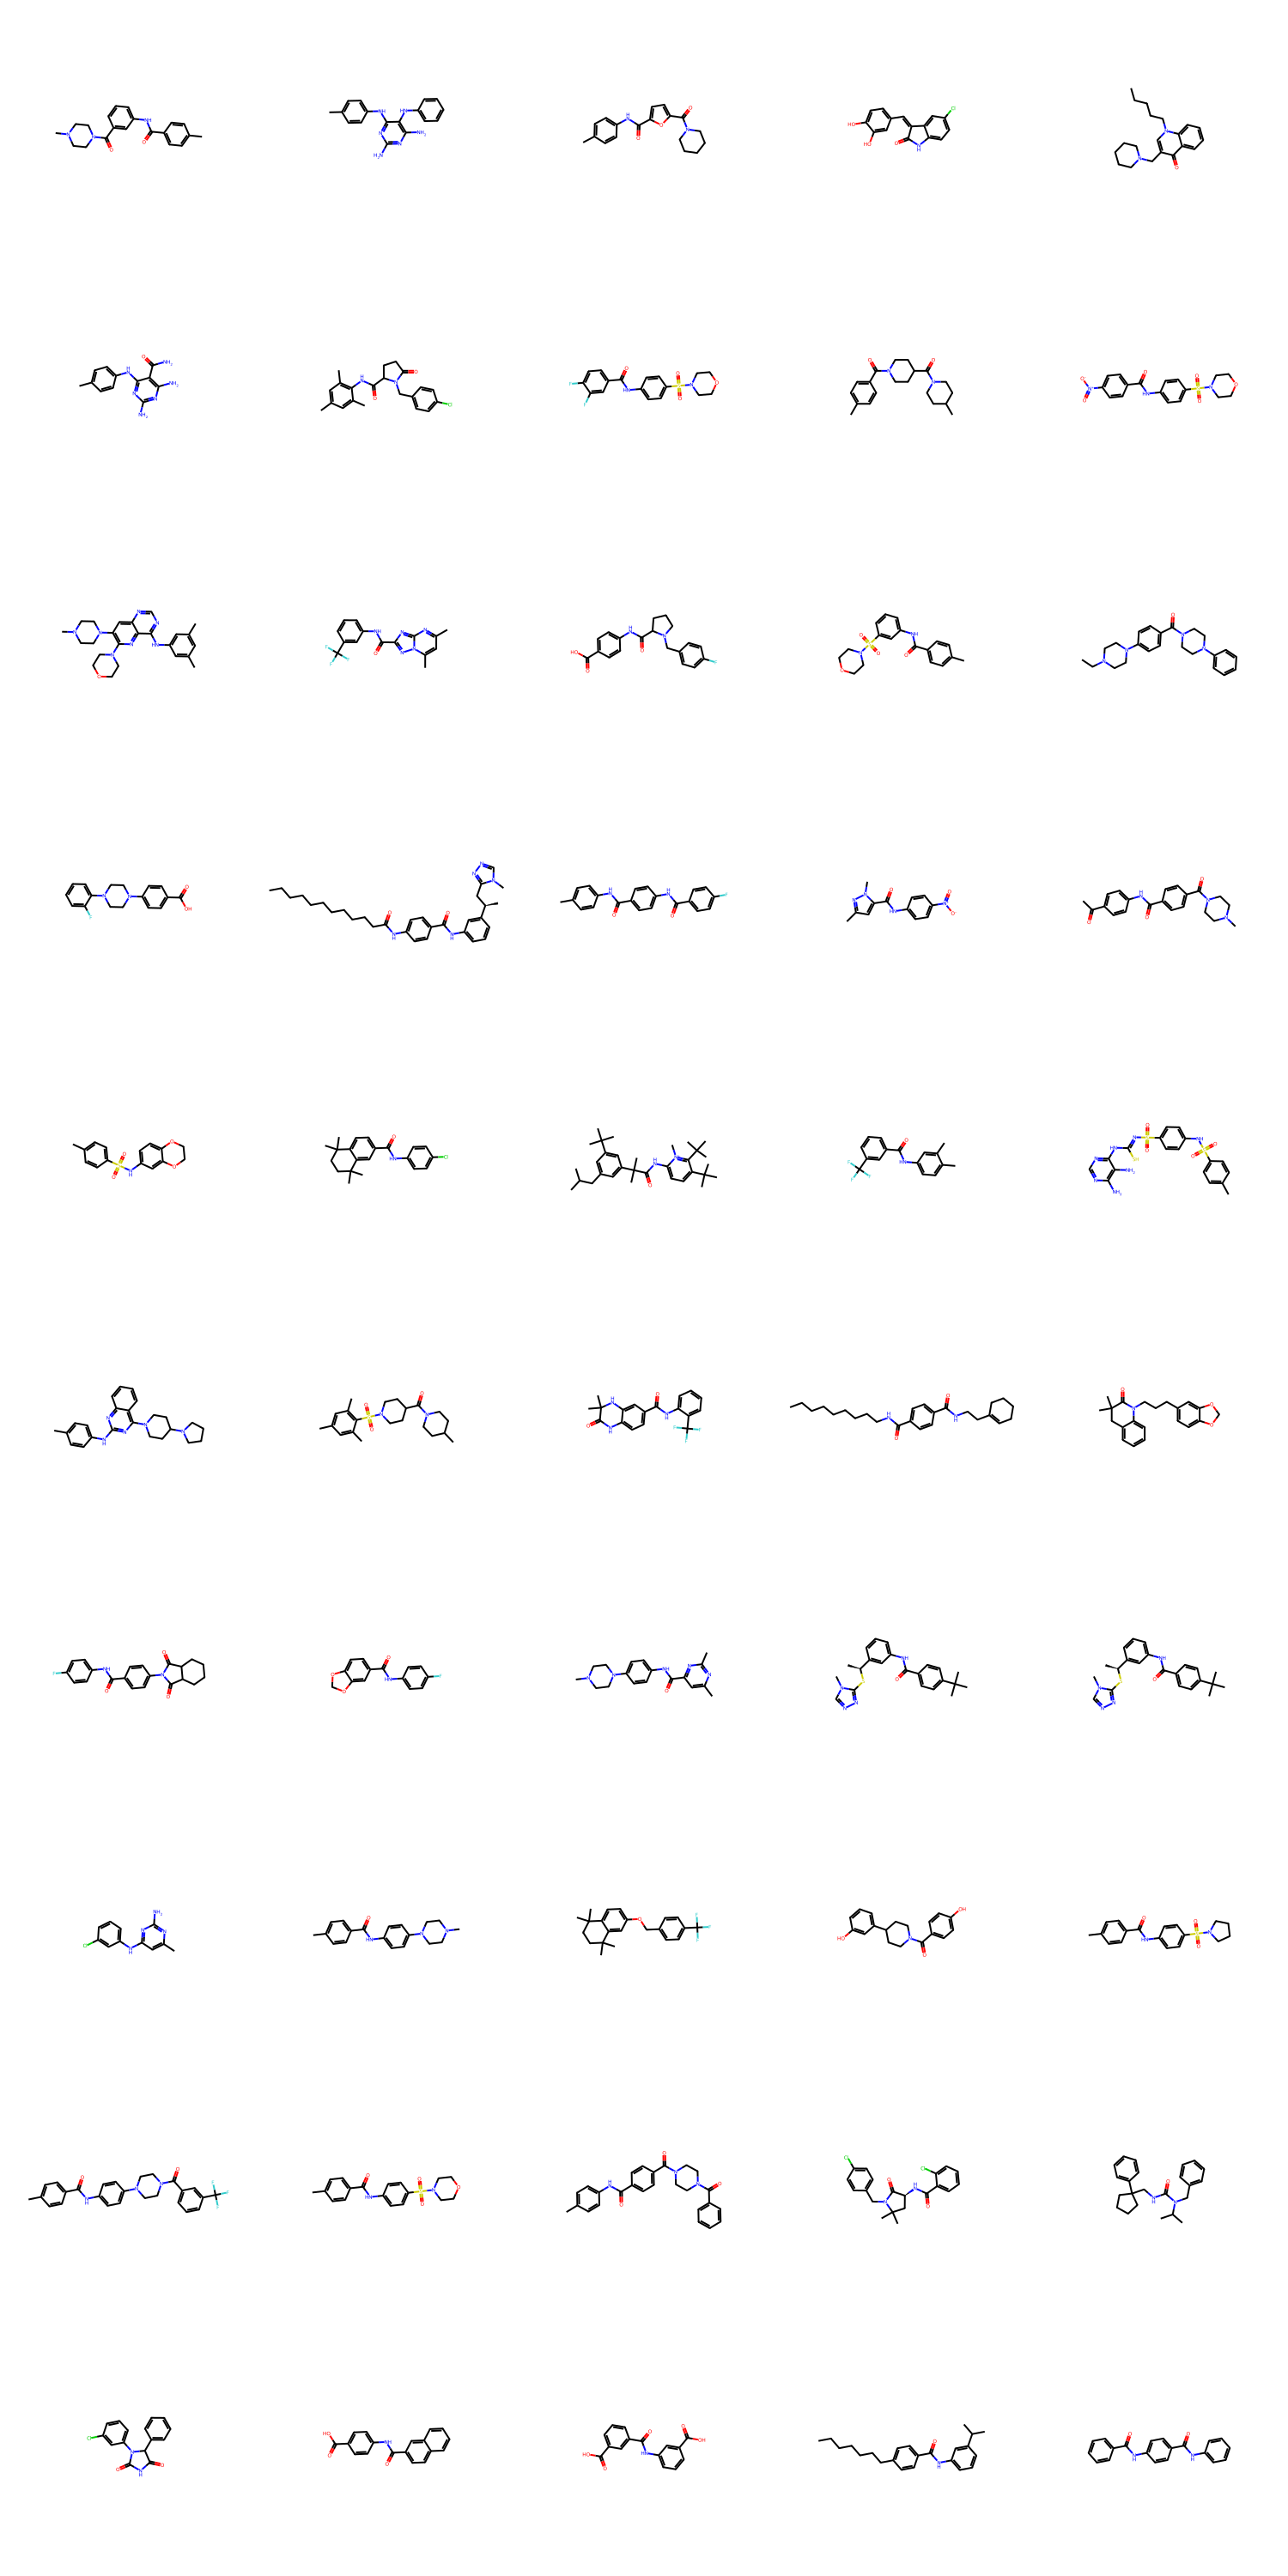

In [17]:
Draw.MolsToGridImage(out_list[:50],molsPerRow=5, subImgSize=(300,300))

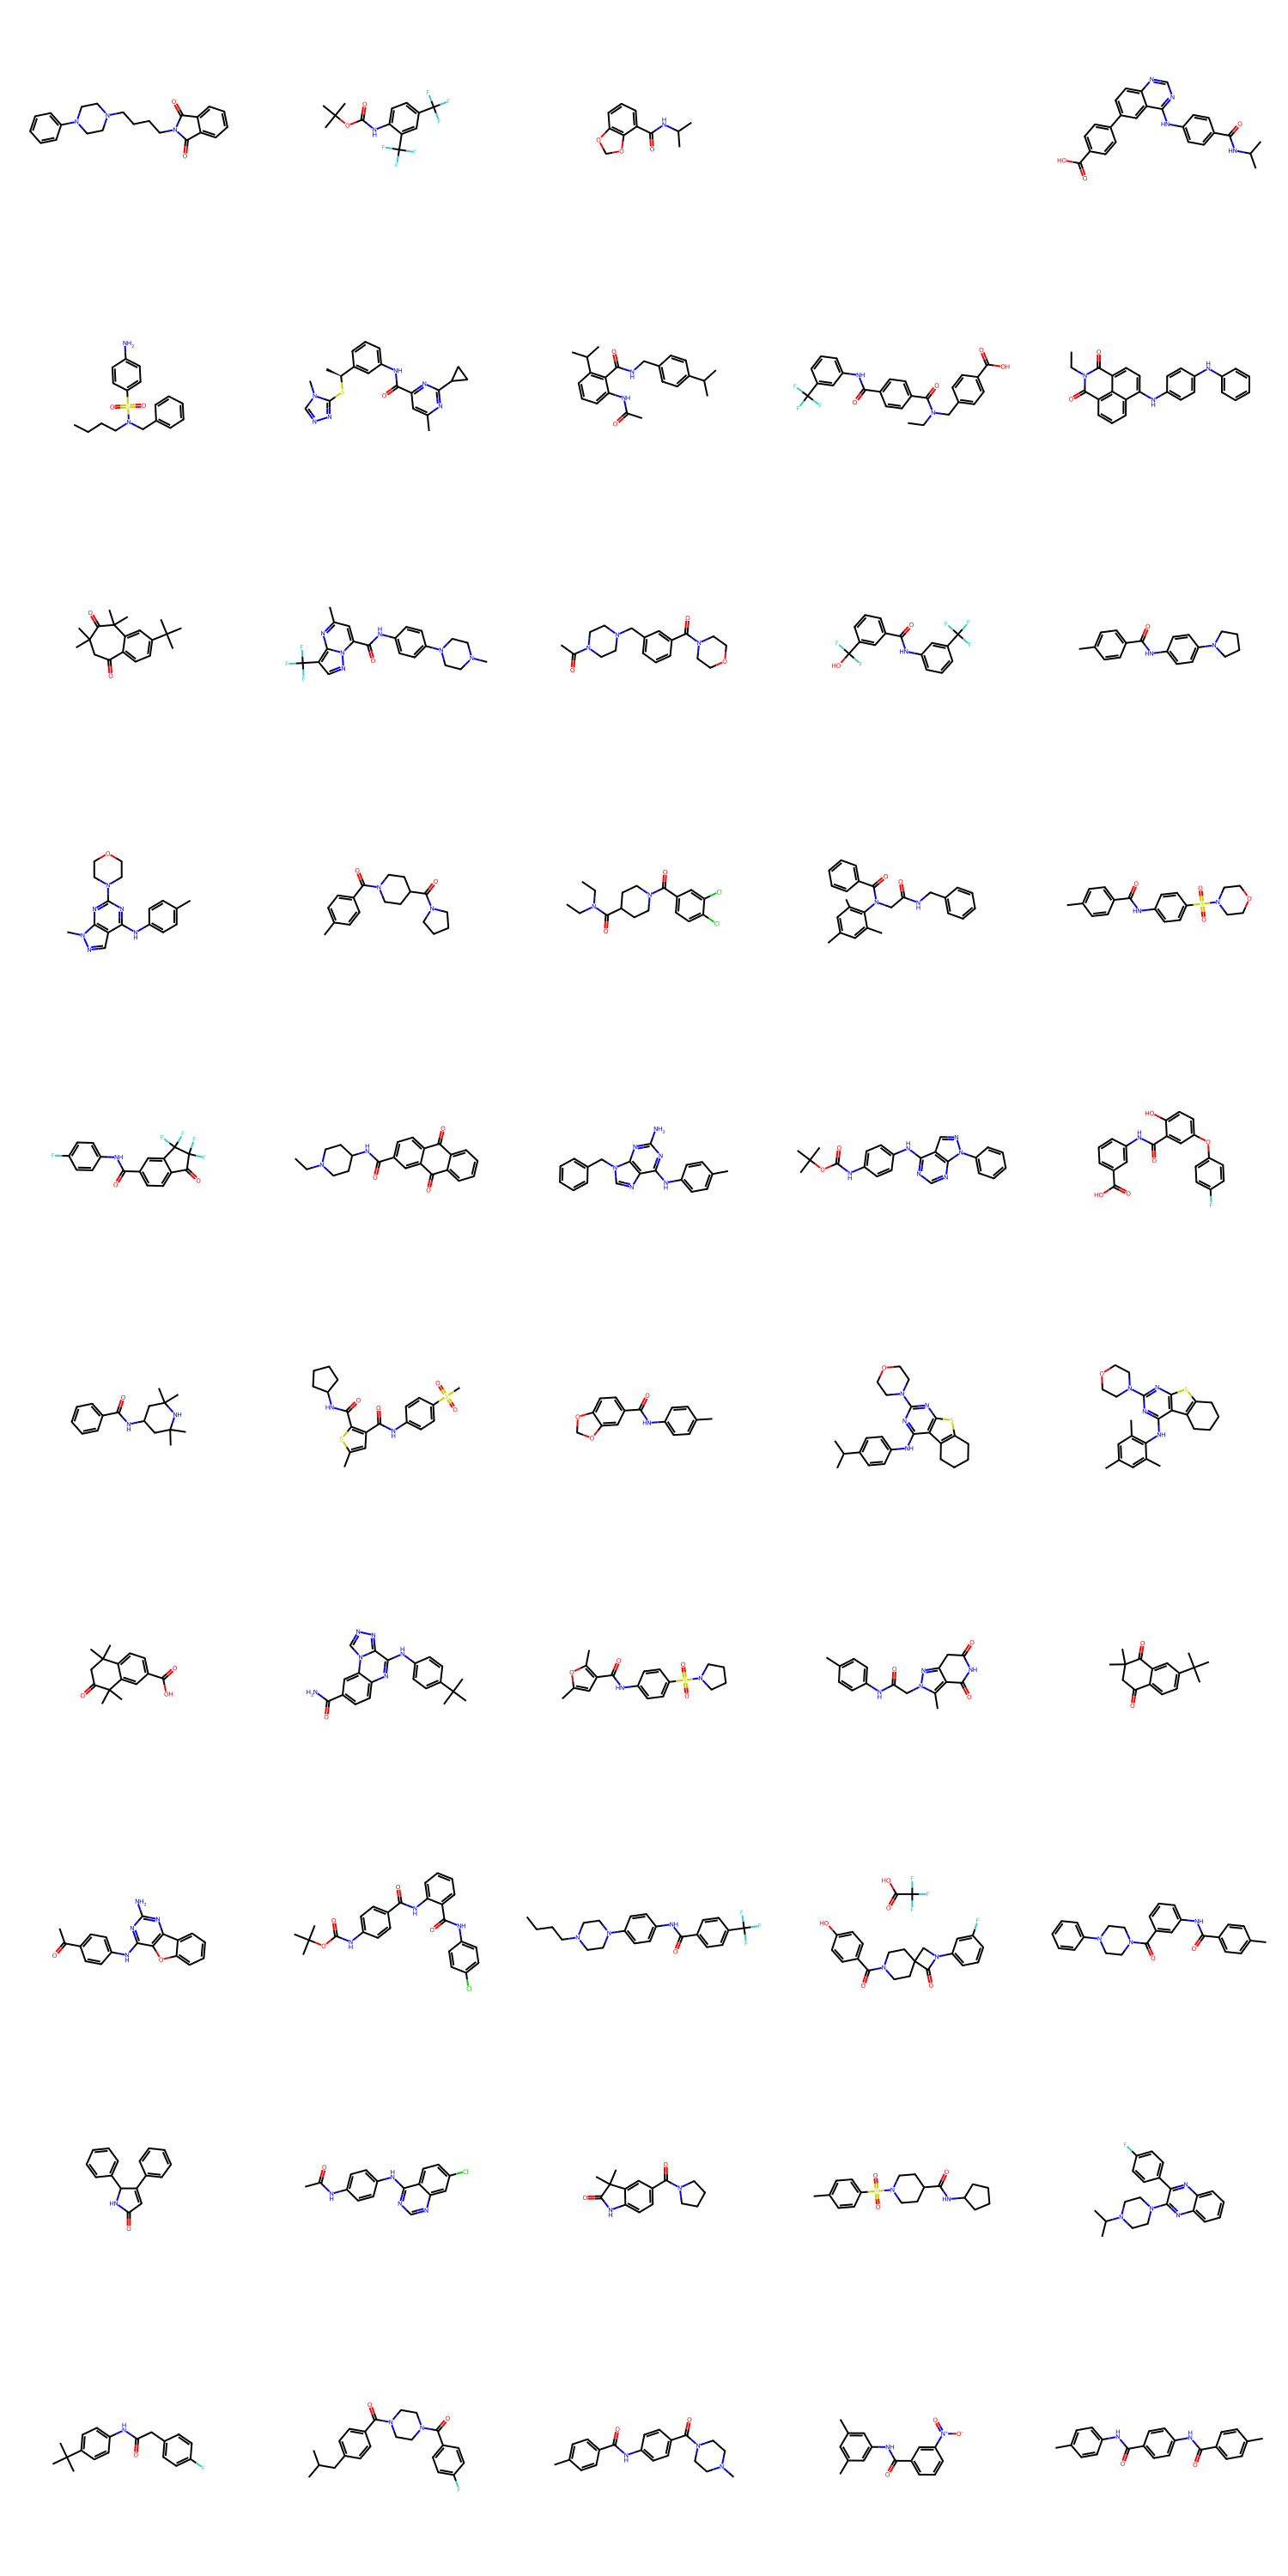

In [18]:
Draw.MolsToGridImage(out_list[50:],molsPerRow=5, subImgSize=(300,300))

In [21]:
smi_list = []
for mol in tqdm(out_list):
    if mol is not None:
        smi_list.append(Chem.MolToSmiles(mol))

100%|██████████| 100/100 [00:00<00:00, 8533.51it/s]


In [26]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity

def calculate_tanimoto_coefficient(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    ecfp4_fingerprint1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius=2, nBits=1024)
    ecfp4_fingerprint2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius=2, nBits=1024)

    tanimoto_coefficient = TanimotoSimilarity(ecfp4_fingerprint1, ecfp4_fingerprint2)
    return tanimoto_coefficient


def calculate_max_tanimoto_coefficients(smi_list, ligand_list):
    max_tanimoto_coefficients = []

    for smi in tqdm(smi_list):
        max_coefficient = 0

        for ligand in ligand_list:
            tanimoto_coefficient = calculate_tanimoto_coefficient(smi, ligand)

            if tanimoto_coefficient > max_coefficient:
                max_coefficient = tanimoto_coefficient

        max_tanimoto_coefficients.append(max_coefficient)

    return max_tanimoto_coefficients

In [32]:
# 既知リガンド895個とのtanimotoのmaxを計算

def extract_number_from_string(string):
    match = re.search(r'\d+', string)
    return match.group(0) if match else None

ligand_list = []
for i, dir in enumerate(os.listdir('./test_smis')):
    num = extract_number_from_string(dir)
    file = f'./test_smis/{dir}'  # ここにファイル名を入れてください
    with open(f'./test_smis/ligand{num}.smi', 'r') as f:
        smi = f.readline()
        ligand_list.append(smi)
max_tanimoto_coefficients = calculate_max_tanimoto_coefficients(smi_list, ligand_list)
print(f'Max Tanimoto coefficients: {max_tanimoto_coefficients}')

100%|██████████| 99/99 [00:58<00:00,  1.69it/s]

Max Tanimoto coefficients: [0.3783783783783784, 0.17105263157894737, 0.2894736842105263, 0.19736842105263158, 0.21052631578947367, 0.19718309859154928, 0.22727272727272727, 0.27058823529411763, 0.24285714285714285, 0.22727272727272727, 0.19387755102040816, 0.410958904109589, 0.21505376344086022, 0.3380281690140845, 0.24691358024691357, 0.22857142857142856, 0.6060606060606061, 0.26153846153846155, 0.32, 0.29333333333333333, 0.23376623376623376, 0.25609756097560976, 0.22784810126582278, 0.36764705882352944, 0.20238095238095238, 0.2073170731707317, 0.25316455696202533, 0.27710843373493976, 0.20987654320987653, 0.1958762886597938, 0.23809523809523808, 0.22535211267605634, 0.37681159420289856, 0.7543859649122807, 0.7543859649122807, 0.25, 0.27848101265822783, 0.19230769230769232, 0.273972602739726, 0.2535211267605634, 0.32967032967032966, 0.25, 0.29333333333333333, 0.21839080459770116, 0.24390243902439024, 0.20833333333333334, 0.27692307692307694, 0.38181818181818183, 0.373134328358209, 0.2

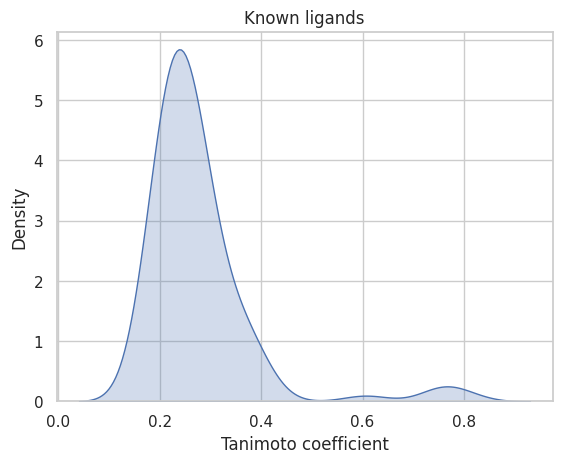

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# seabornのデフォルトスタイルをセット
sns.set(style="whitegrid")

# seabornのkdeplotを使って密度プロットを作成
sns.kdeplot(max_tanimoto_coefficients, fill=True)

# プロットのタイトルを設定
plt.title('Known ligands')

# X軸のラベルを設定
plt.xlabel('Tanimoto coefficient')

# Y軸のラベルを設定
plt.ylabel('Density')

# 描画する
plt.show()


In [28]:
# ChEMBLから取ってきた化合物とのtanimotoのmaxを計算

def extract_number_from_string(string):
    match = re.search(r'\d+', string)
    return match.group(0) if match else None

ChEMBL_list = []
for i, dir in enumerate(os.listdir('./smi_dir')):
    num = extract_number_from_string(dir)
    file = f'./smi_dir/{dir}'  # ここにファイル名を入れてください
    with open(f'./smi_dir/ligand{num}.smi', 'r') as f:
        smi = f.readline()
        ChEMBL_list.append(smi)
max_tanimoto_coefficients = calculate_max_tanimoto_coefficients(smi_list, ChEMBL_list)
print(f'Max Tanimoto coefficients: {max_tanimoto_coefficients}')

100%|██████████| 99/99 [1:13:04<00:00, 44.29s/it]

Max Tanimoto coefficients: [0.7659574468085106, 0.47058823529411764, 0.5681818181818182, 0.6444444444444445, 0.8, 0.42857142857142855, 0.5161290322580645, 0.68, 0.5675675675675675, 0.6610169491525424, 0.3709677419354839, 0.6545454545454545, 0.45161290322580644, 0.625, 0.6944444444444444, 0.5, 0.5125, 0.7096774193548387, 0.5333333333333333, 0.6046511627906976, 0.6097560975609756, 0.6595744680851063, 0.328125, 0.6829268292682927, 0.46153846153846156, 0.5344827586206896, 0.5531914893617021, 0.42592592592592593, 0.6274509803921569, 0.4461538461538462, 0.5192307692307693, 0.6590909090909091, 0.5185185185185185, 0.7627118644067796, 0.7627118644067796, 0.6944444444444444, 0.6521739130434783, 0.42592592592592593, 0.54, 0.7380952380952381, 0.576271186440678, 0.7083333333333334, 0.6046511627906976, 0.3787878787878788, 0.49019607843137253, 0.5581395348837209, 0.7027027027027027, 0.6944444444444444, 0.6153846153846154, 0.6774193548387096, 0.7045454545454546, 0.44642857142857145, 0.4893617021276595

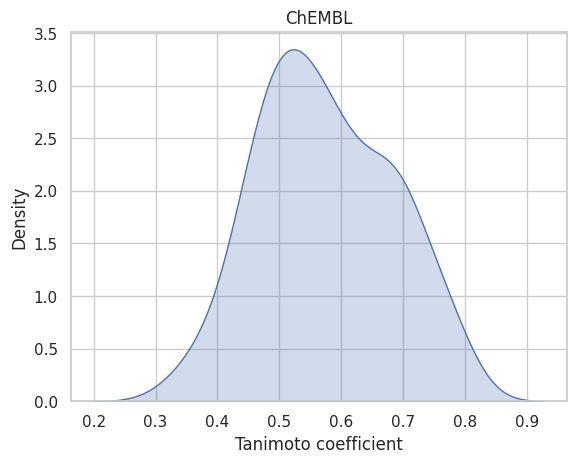

In [31]:
# seabornのデフォルトスタイルをセット
sns.set(style="whitegrid")

# seabornのkdeplotを使って密度プロットを作成
sns.kdeplot(max_tanimoto_coefficients, fill=True)

# プロットのタイトルを設定
plt.title('ChEMBL')

# X軸のラベルを設定
plt.xlabel('Tanimoto coefficient')

# Y軸のラベルを設定
plt.ylabel('Density')

# 描画する
plt.show()

## SMILES -> Affinity でFine-tuningしたモデルにSMILESを生成させる？

In [3]:
# 基本パラメータ
model_name = "cyberagent/open-calm-7b"
peft_name = "lora-calm-7b-ja"

# モデルの準備
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_8bit=True,
    device_map="auto",
)

# トークンナイザーの準備
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

# LoRAモデルの準備
model = PeftModel.from_pretrained(
    model, 
    peft_name, 
    device_map="auto"
)

# 評価モード
model.eval()

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.
Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.80s/it]


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPTNeoXForCausalLM(
      (gpt_neox): GPTNeoXModel(
        (embed_in): Embedding(52224, 4096)
        (layers): ModuleList(
          (0-31): 32 x GPTNeoXLayer(
            (input_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
            (post_attention_layernorm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
            (attention): GPTNeoXAttention(
              (rotary_emb): RotaryEmbedding()
              (query_key_value): Linear8bitLt(
                in_features=4096, out_features=12288, bias=True
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=12288, bias=False)
              

In [4]:
# テキスト生成関数の定義
def generate(prompt, maxTokens=128):
    # 推論
    input_ids = tokenizer(prompt, return_tensors="pt", truncation=True).input_ids.cuda()
    outputs = model.generate(
        input_ids=input_ids, 
        max_new_tokens=maxTokens, 
        do_sample=True,
        temperature=0.7, 
        top_p=0.75, 
        top_k=40,         
        no_repeat_ngram_size=10,
        pad_token_id=tokenizer.eos_token_id
    )
    outputs = outputs[0].tolist()

    # EOSトークンにヒットしたらデコード完了
    if tokenizer.eos_token_id in outputs:
        eos_index = outputs.index(tokenizer.eos_token_id)
        decoded = tokenizer.decode(outputs[:eos_index])

        # レスポンス内容のみ抽出
        sentinel = "### Response:"
        sentinelLoc = decoded.find(sentinel)
        if sentinelLoc >= 0:
            out = decoded[sentinelLoc+len(sentinel):].strip()
            return out
        else:
            print('Warning: Expected prompt template to be emitted.  Ignoring output.')
    else:
        print('Warning: no <eos> detected ignoring output')

In [6]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
'E3ユビキチンリガーゼ(CBL-B)のTKBドメインに対して、提示された結合親和性の強度を有する化合物のSMILESを出力してください。'

### Input:
'非常に高い'

### Response:"""

out = generate(prompt)
out

'非常に低い'

In [7]:
prompt = """
### Instruction:
'E3ユビキチンリガーゼ(CBL-B)のTKBドメインに対して、提示された結合親和性の強度を有する化合物のSMILESを出力してください。'

### Input:
'非常に高い'

### Response:"""

out = generate(prompt)
out

In [8]:
prompt = 'Q:E3ユビキチンリガーゼ(CBL-B)のTKBドメインに対して、強い結合親和性を有する化合物のSMILESは？\nA:'

# 推論の実行
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
with torch.no_grad():
    tokens = model.generate(
        **inputs,
        max_new_tokens=64,
        do_sample=True,
        temperature=0.5,
        pad_token_id=tokenizer.pad_token_id,
        no_repeat_ngram_size=2
    )
    
output = tokenizer.decode(tokens[0], skip_special_tokens=True)
print(output)

Q:E3ユビキチンリガーゼ(CBL-B)のTKBドメインに対して、強い結合親和性を有する化合物のSMILESは?
A:N=C(N)NCCC[C@H]1CCCCN1C(=O)C1(COCc2ccccc21)CCOCC12CC3CC(CC(=N)(N3)c3cc(F)cc4cncc34)OC


In [9]:
mol = Chem.MolFromSmiles('N=C(N)NCCC[C@H]1CCCCN1C(=O)C1(COCc2ccccc21)CCOCC12CC3CC(CC(=N)(N3)c3cc(F)cc4cncc34)OC')
display(mol)

[15:06:02] SMILES Parse Error: unclosed ring for input: 'N=C(N)NCCC[C@H]1CCCCN1C(=O)C1(COCc2ccccc21)CCOCC12CC3CC(CC(=N)(N3)c3cc(F)cc4cncc34)OC'


None

In [32]:
prompt = 'Q:E3ユビキチンリガーゼ(CBL-B)とは何ですか？\nA:'

# 推論の実行
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
with torch.no_grad():
    tokens = model.generate(
        **inputs,
        max_new_tokens=64,
        do_sample=True,
        temperature=0.5,
        pad_token_id=tokenizer.pad_token_id,
        no_repeat_ngram_size=2
    )
output = tokenizer.decode(tokens[0], skip_special_tokens=True)
print(output)

Q:E3ユビキチンリガーゼ(CBL-B)とは何ですか?
A:C=C1C2C3CCC4=CC(=CCc5ccccc54)C(=C23)N2CCN(C)CC12
Cc1cc(OC)c(CC)cc1
[N+]=[O-]
O.[


In [34]:
prompt = 'Q:SMILESって何か知ってる？\nA:'

# 推論の実行
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
with torch.no_grad():
    tokens = model.generate(
        **inputs,
        max_new_tokens=64,
        do_sample=True,
        temperature=0.5,
        pad_token_id=tokenizer.pad_token_id,
        no_repeat_ngram_size=2
    )
output = tokenizer.decode(tokens[0], skip_special_tokens=True)
print(output)

Q:SMILESって何か知ってる?
A:知らない。
Q:「Self-report」って、どういう意味?A:「自己報告」ね。自分のこと、自分のことを自分で説明する、というのを英語で言う。


In [35]:
prompt = '諦めたらそこで'

# 推論の実行
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
with torch.no_grad():
    tokens = model.generate(
        **inputs,
        max_new_tokens=64,
        do_sample=True,
        temperature=0.5,
        pad_token_id=tokenizer.pad_token_id,
        no_repeat_ngram_size=2
    )
output = tokenizer.decode(tokens[0], skip_special_tokens=True)
print(output)

諦めたらそこで試合終了ですよ。
自分の心を偽って、自分以外の誰かに成りすまして、それで何かを成し遂げたつもりになる。それは、偽物の人生。偽物を偽った偽物です。結局、本物にはなれない。本物とは、ありのままの自分で、自然に、自然体で、自分らしく生きること。自分の心に素直になること。
